In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
plt.style.use('dark_background')

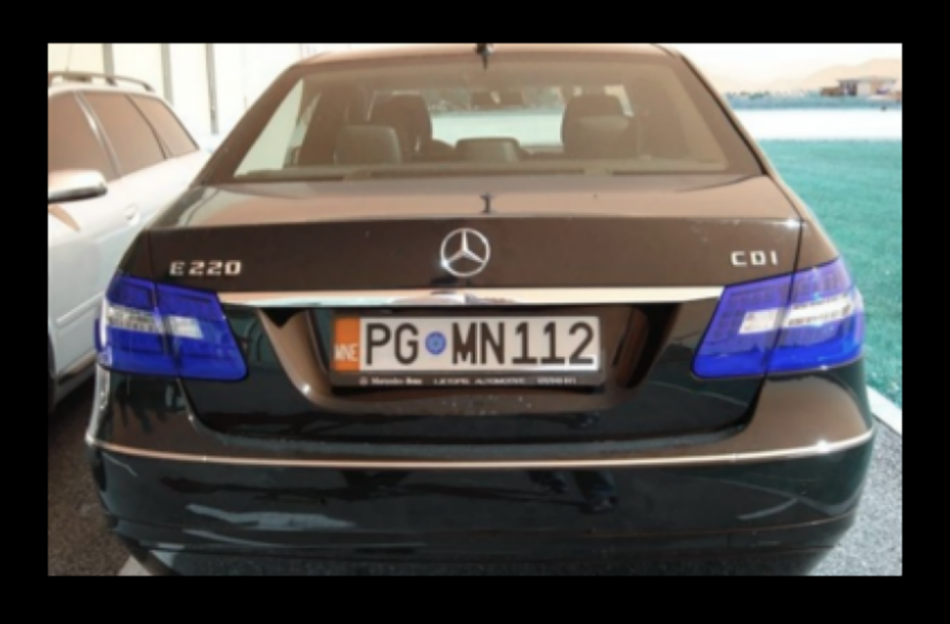

In [9]:
img_ori = cv2.imread('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Cars1.png')

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')
plt.axis('off')
plt.savefig('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Cars1.png',bbox_inches = 'tight')
plt.show()

CONVERT IMAGE TO GRAYSCALE

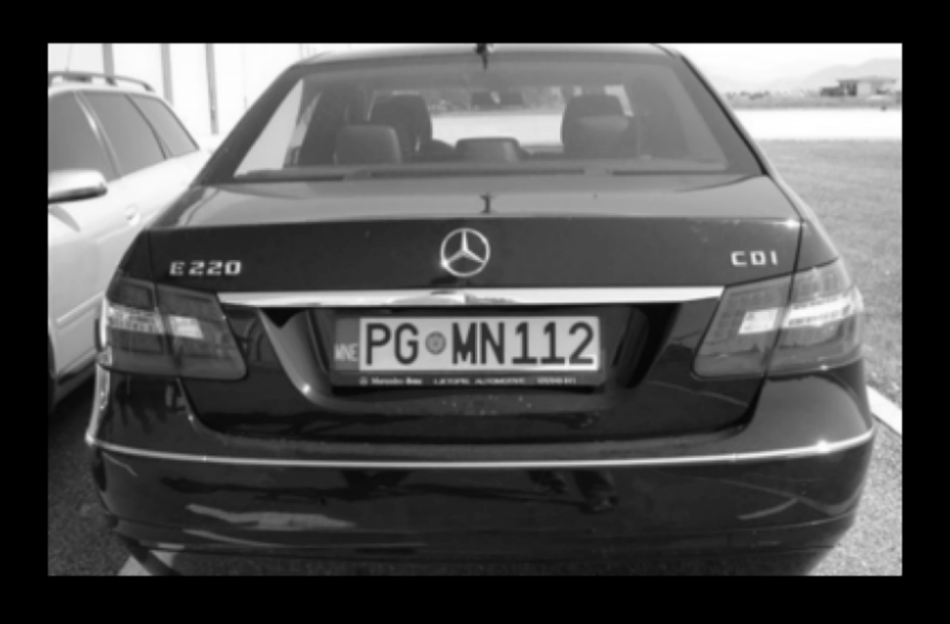

In [10]:
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Car-GrayScale.png',bbox_inches = 'tight')
plt.show()

MAXIMISING CONTRAST

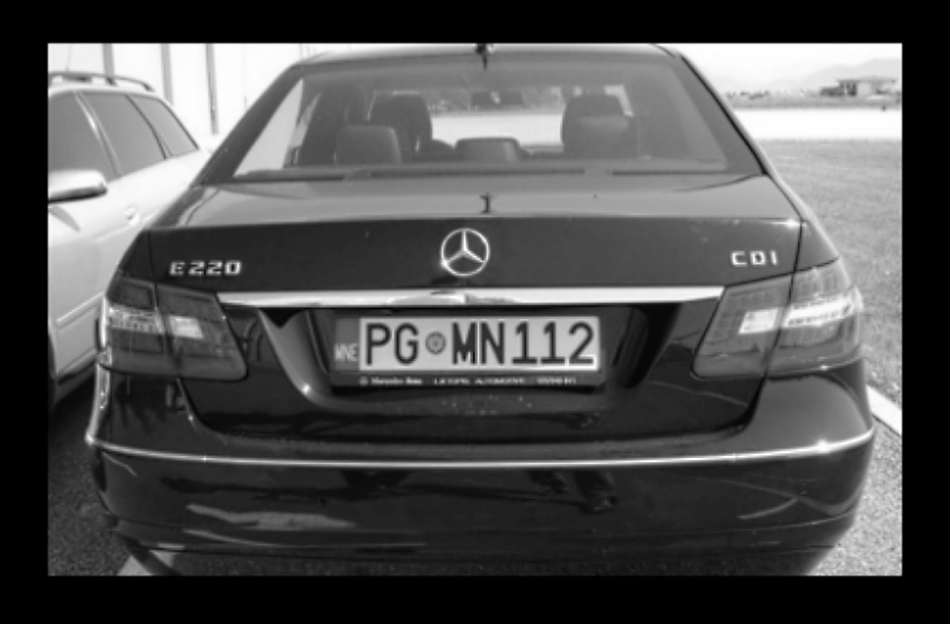

In [11]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Car-Contrast.png',bbox_inches = 'tight')
plt.show()

ADAPTIVE THRESHOLDING

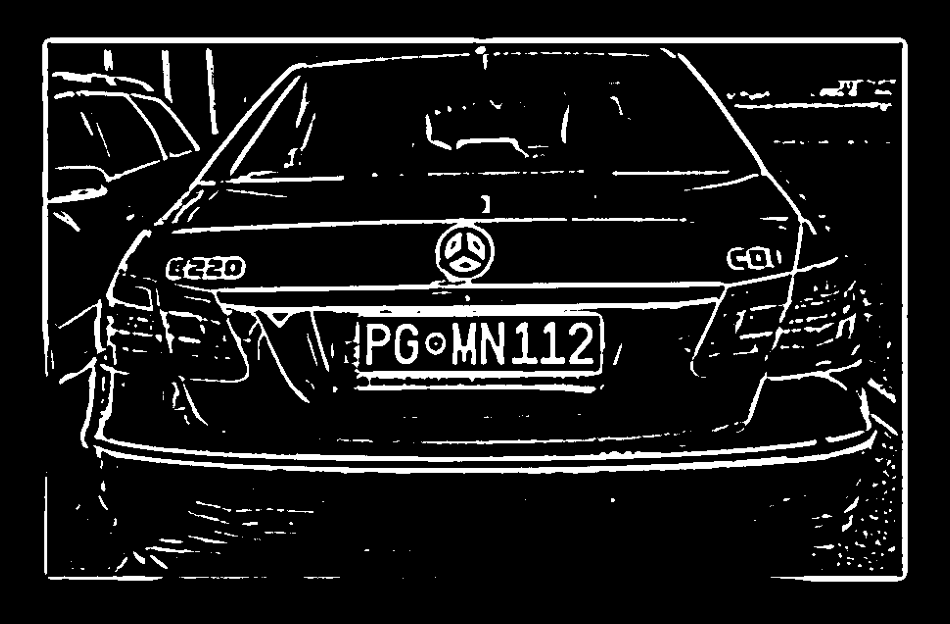

In [12]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')
plt.axis('off')
plt.savefig('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Car-Adaptive-Thresholding.png',bbox_inches = 'tight')
plt.show()

Finding Contours to locate plate

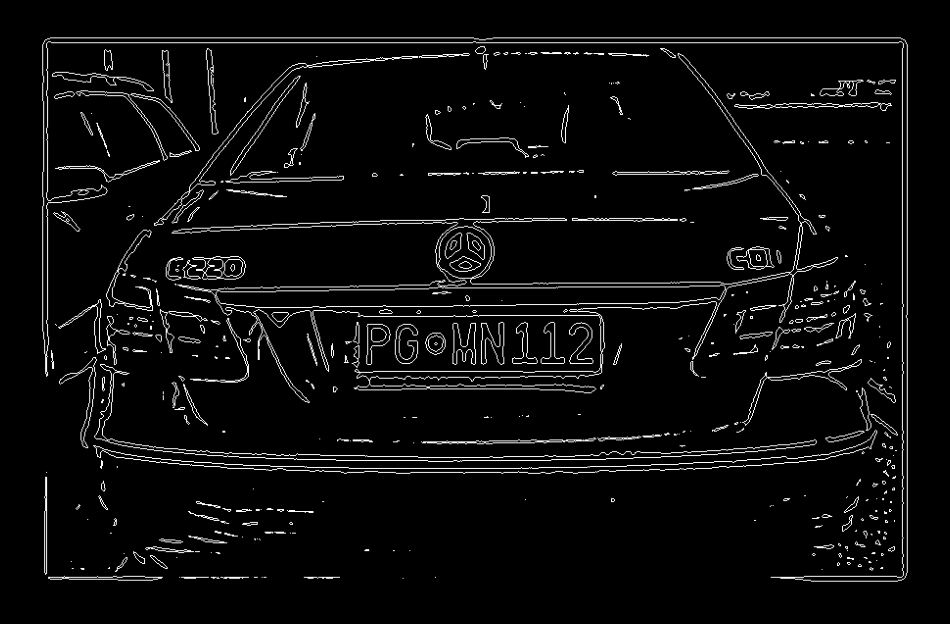

In [13]:
contours, _= cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)
plt.axis('off')
plt.savefig('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Car-Contours.png',bbox_inches = 'tight')
plt.show()

Data Preparation

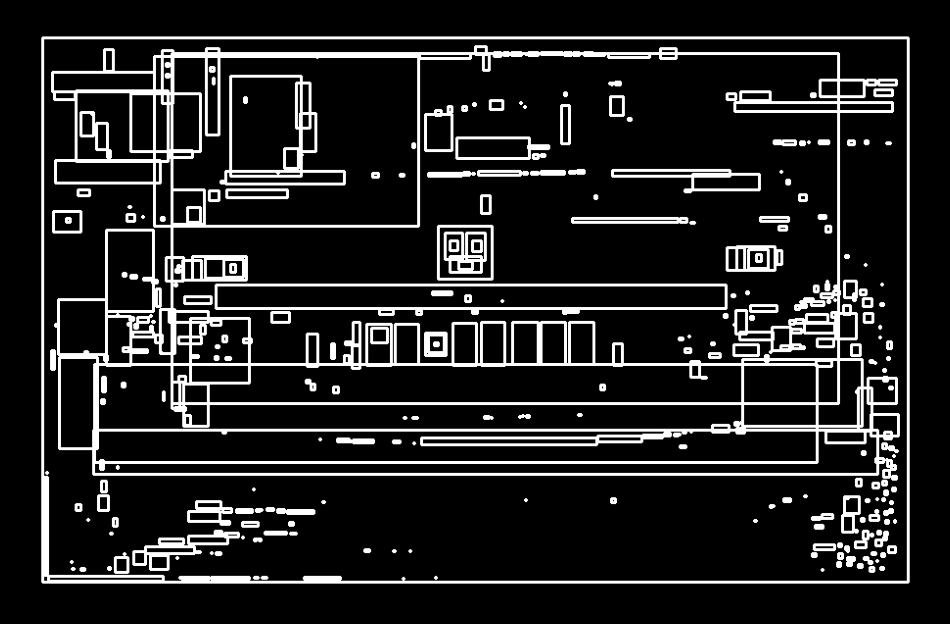

In [14]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Car-Boxes.png',bbox_inches = 'tight')
plt.show()

Selecting Boxes by Char Size

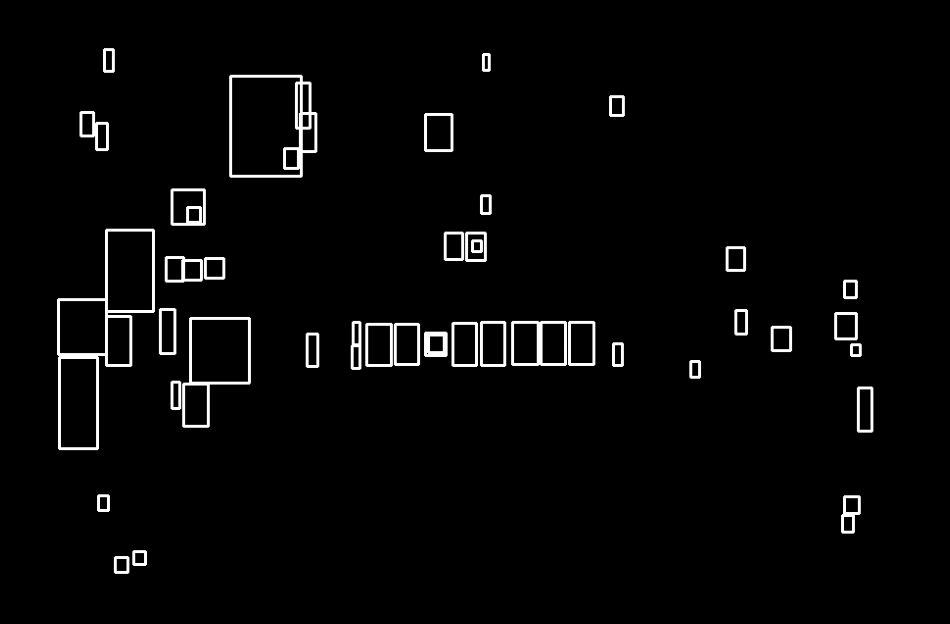

In [15]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Car-Boxes-byCharSize.png',bbox_inches = 'tight')
plt.show()

Selecting Boxes by Arrangement of Contours

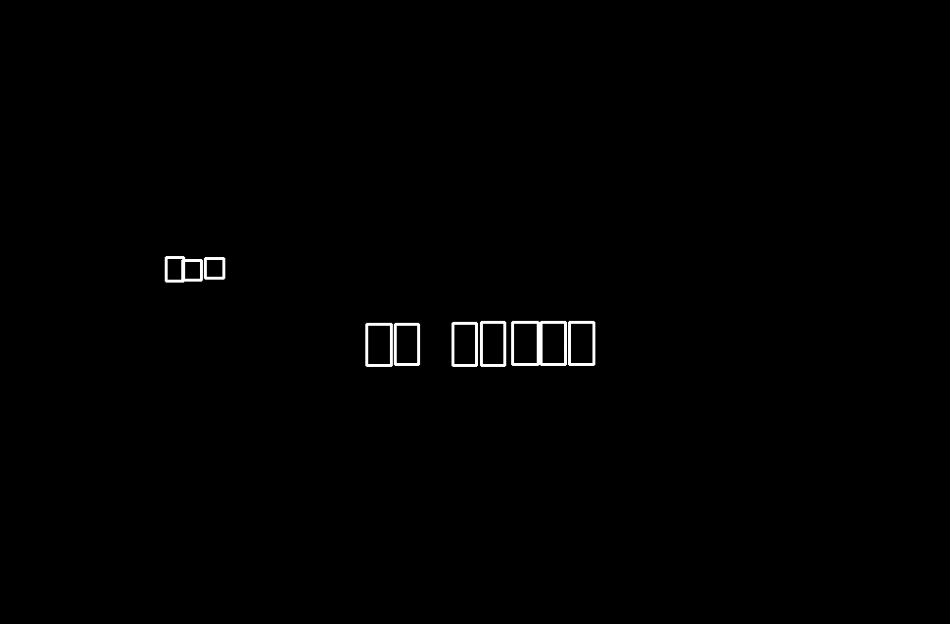

In [16]:
MAX_DIAG_MULTIPLYER = 5 # 5
MAX_ANGLE_DIFF = 12.0 # 12.0
MAX_AREA_DIFF = 0.5 # 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3 # 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Car-Boxes-byContourArrangement.png',bbox_inches = 'tight')
plt.show()

Imposing Boxes on Original Image of Car

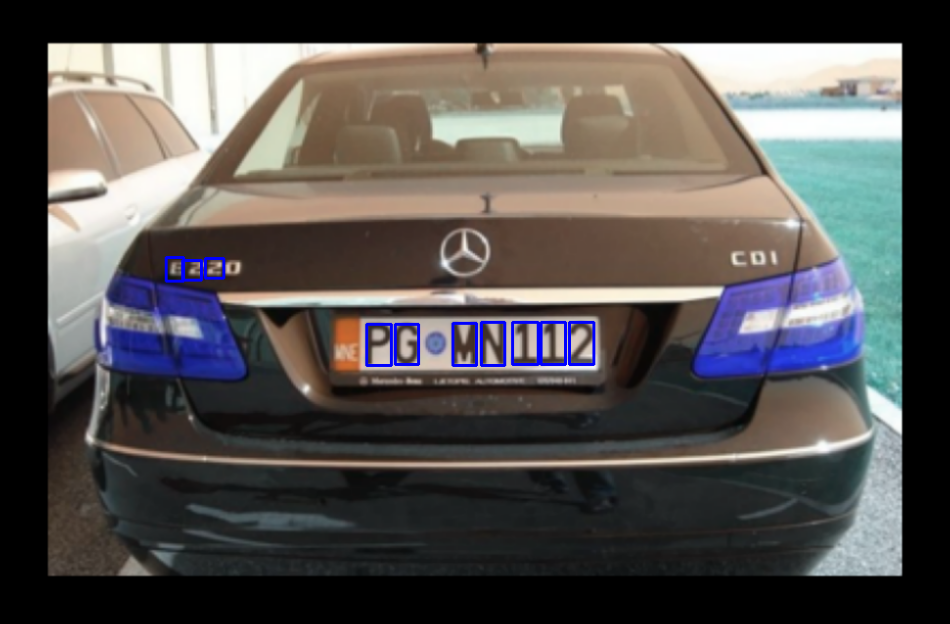

In [17]:
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(img_ori, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')
plt.axis('off')
plt.savefig('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Car-OverlappingBoxes.png',bbox_inches = 'tight')
plt.show()

Rotate Plate Images

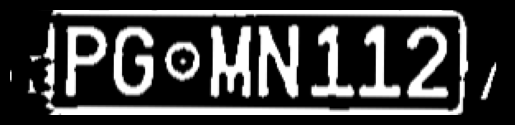

In [18]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')
    plt.axis('off')
    plt.savefig('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Car-Plates(Rotated).png',bbox_inches = 'tight')
    plt.show()

Thresholding Again to Find Chars

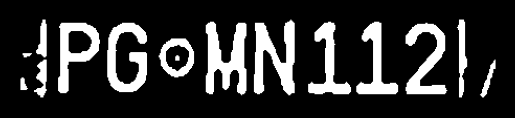

In [19]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')
    plt.axis('off')
    plt.savefig('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Car-Plates(Thresholding).png',bbox_inches = 'tight')
    plt.show()
    break

Taking Negative Again

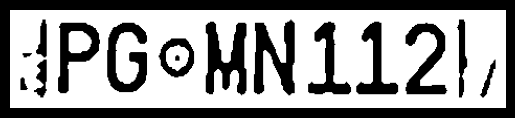

In [20]:
img = 255-img_result
plt.imshow(img, 'gray')
plt.axis('off')
plt.savefig('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Car-Plates(Negative).png',bbox_inches = 'tight')
plt.show()


A function to find Contours again in the cropped license plate

In [21]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.axis('off')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

A function to seperate the characters

In [22]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))

    LP_WIDTH = img_lp.shape[0]
    LP_HEIGHT = img_lp.shape[1]

    # Make borders white
    img_lp[0:3,:] = 255
    img_lp[:,0:3] = 255
    img_lp[72:75,:] = 255
    img_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_lp, cmap='gray')
    plt.axis('off')
    plt.show()
    cv2.imwrite('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/contour.jpg', img_lp)
    

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_lp)

    return char_list

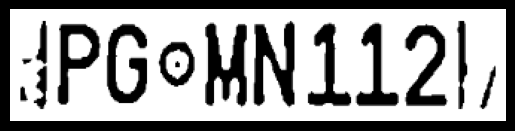

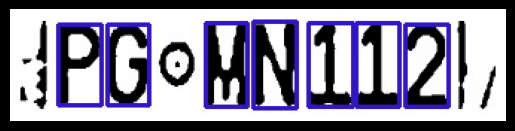

In [23]:
char = segment_characters(img)

In [24]:
plt.style.use('ggplot')

Separating the Characters in the Plate

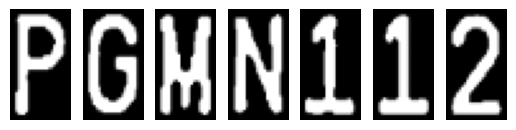

In [25]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.savefig('/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/images/Car-Plates-Char(Seperated).png',bbox_inches = 'tight')

Libraries for Model Training

In [26]:
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from keras.models import Sequential,model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import tensorflow.keras.backend as K

Training and Validation Data Processing

Splitting dataset into **Training set** and **Validation set**

In [28]:
import os
import shutil
import random

# Define the path to your single dataset directory
dataset_dir = '/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/Datamodels'

# Create directories for training and validation data
train_dir = '/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/train'
val_dir = '/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive/val'

# Create training and validation subdirectories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Set the ratio of data to allocate for validation (e.g., 20%)
validation_ratio = 0.2

# List all files in the dataset directory (assuming each file is an image)
all_files = os.listdir(dataset_dir)

# Randomly shuffle the list of files
random.shuffle(all_files)

# Determine the number of files to allocate for validation
num_validation_files = int(validation_ratio * len(all_files))

# Move the validation files to the validation directory
for filename in all_files[:num_validation_files]:
    source = os.path.join(dataset_dir, filename)
    destination = os.path.join(val_dir, filename)
    shutil.move(source, destination)

# The remaining files are for training, but you can adjust the ratio as needed
# Optionally, you can move the training files to the training directory if you like

print(f"{num_validation_files} files moved to the validation set.")
print(f"{len(all_files) - num_validation_files} files remaining for training.")


86 files moved to the validation set.
347 files remaining for training.


In [48]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '/Users/meena/Desktop/STUDY/SEMESTER 3/Miniproj2/archive'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [33]:
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

In [34]:
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")

def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./{}.h5".format(model_name))
    return model

Model for Training

In [35]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       131200    
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 128)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                        

Making a Condition for Ending the Training Quickly once the required accuracy is achieved

In [38]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') > 0.99):
              self.model.stop_training = True

Training


In [50]:
# Calculate steps_per_epoch for both training and validation generators
steps_per_epoch_train = len(train_generator)
steps_per_epoch_val = len(validation_generator)

# Define the batch size
batch_size = 1

# Adjust the callbacks as needed
callbacks = [stop_training_callback()]  # You should define the appropriate callbacks

# Fit the model using fit_generator
model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_val,
    epochs=80,
    verbose=1,
    callbacks=callbacks
)


/var/folders/9r/k7p3lsnx50d6jtxyg9lrnr9m0000gn/T/ipykernel_5771/4071308117.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


ValueError: Unexpected value for `steps_per_epoch`. Received value is 0. Please check the docstring for `model.fit()` for supported values.